In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import timedelta

## Import data

(23549, 5)

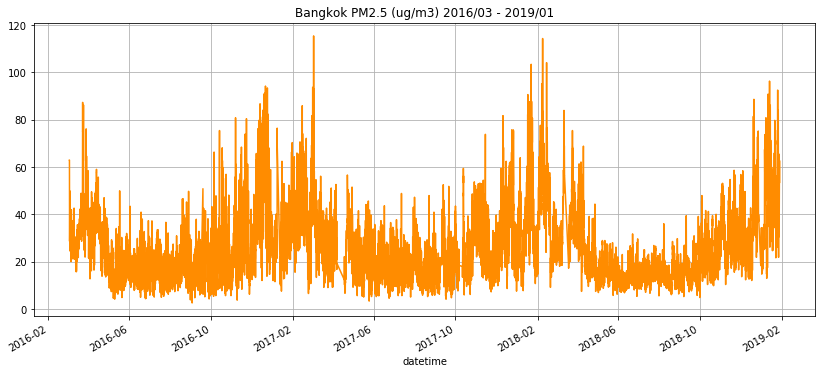

In [2]:
df = pd.read_csv('Bangkok_pm25.csv')
df.rename(columns={'UTC Hour':'Hour'}, inplace=True)
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]) + pd.Timedelta(hours=7) # UTC to Bangkok time
df.index = df['datetime']
df.Hour = df.index.hour # UTC hour to UTC+7
df.drop(columns=['PM10_mask','Retrospective','datetime'],inplace=True)
df['PM2.5'].plot(figsize=(14,6),title="Bangkok PM2.5 (ug/m3) 2016/03 - 2019/01", color='darkorange', grid=True)
df.shape

C:\Users\Poom__000\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


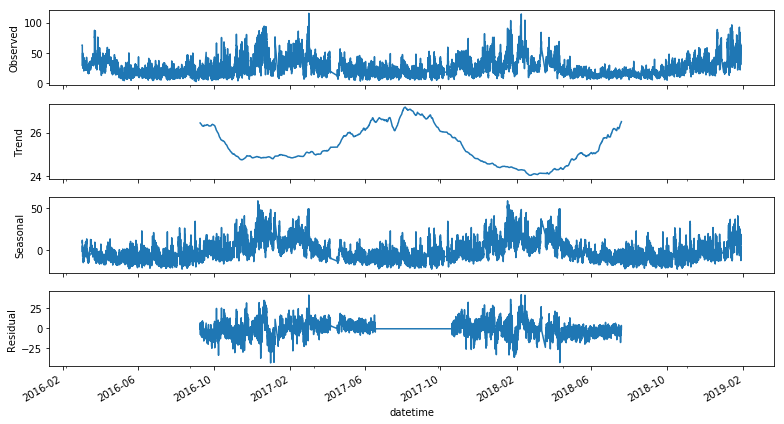

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 6
result = seasonal_decompose(df['PM2.5'], model='addtive', freq=365*24)
fig = result.plot()
plt.show()

## Add features

In [4]:
# Date features
df['dayofweek'] = df.index.dayofweek 
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.weekofyear
df['quarter'] = df.index.quarter
#df['Last24hrs_mean'] = df['PM2.5'].rolling(24).mean().shift(24)
# add holiday?

df.nlargest(5, 'PM2.5') # top 5 highest pm2.5

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter
datetime,,,,,,,,,
2017-03-03 09:00:00,2017,3,3,9,115.4,4,62,9,1
2018-02-08 10:00:00,2018,2,8,10,114.3,3,39,6,1
2018-02-14 08:00:00,2018,2,14,8,104.1,2,45,7,1
2018-01-22 08:00:00,2018,1,22,8,103.4,0,22,4,1
2018-01-22 09:00:00,2018,1,22,9,100.8,0,22,4,1


In [5]:
df.nsmallest(5, 'PM2.5')

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter
datetime,,,,,,,,,
2016-09-02 22:00:00,2016,9,2,22,2.5,4,246,35,3
2016-09-02 23:00:00,2016,9,2,23,2.9,4,246,35,3
2016-09-02 20:00:00,2016,9,2,20,3.0,4,246,35,3
2016-09-02 19:00:00,2016,9,2,19,3.2,4,246,35,3
2017-05-25 08:00:00,2017,5,25,8,3.3,3,145,21,2


In [6]:
## Lag data (previous hours)
def add_Lag(df, lags):
    for i in lags:
        df[f'lag_{i}'] = df['PM2.5'].shift(i)
    return df
#df = add_Lag(df, [1]) # [24,48,72,96,120,144,168] , range(1,25)

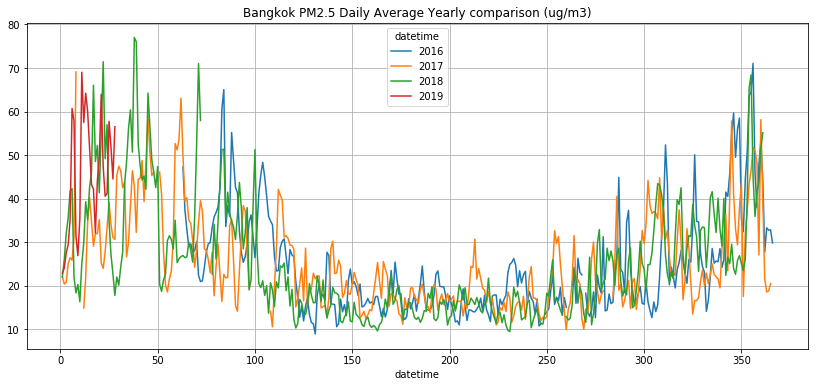

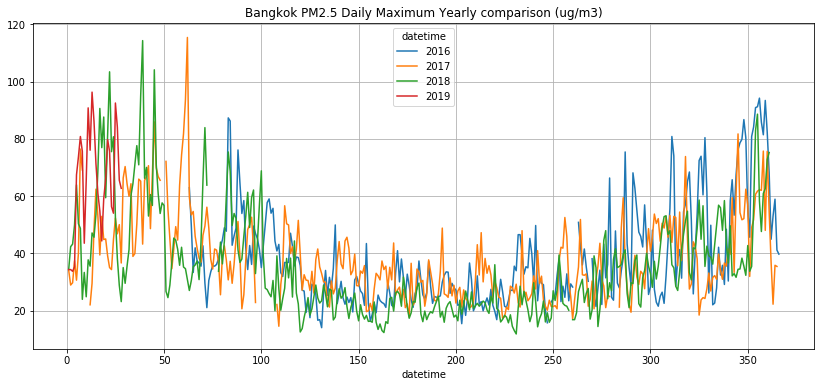

In [7]:
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='PM2.5', aggfunc='mean')
pv.plot(title="Bangkok PM2.5 Daily Average Yearly comparison (ug/m3)",figsize=(14,6), grid=True)

pv2 = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='PM2.5', aggfunc='max')
pv2.plot(title="Bangkok PM2.5 Daily Maximum Yearly comparison (ug/m3)",figsize=(14,6), grid=True)

Text(0.5,15,'dayofweek (Mon=0, Sun=6)')

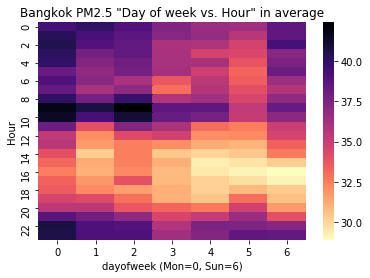

In [8]:
peak_months = df.loc[(df['Month'] == 12) | (df['Month'] <= 4)]
fig, ax = plt.subplots(figsize=(6,4)) 
hrvsday = peak_months.pivot_table(values='PM2.5',index='Hour',columns='dayofweek',aggfunc='mean')
ax.set_title('Bangkok PM2.5 "Day of week vs. Hour" in average')
sns.heatmap(hrvsday,cmap='magma_r', ax=ax) #  Monday=0, Sunday=6
ax.set_xlabel('dayofweek (Mon=0, Sun=6)')

In [9]:
# weather features
weather = pd.read_csv('patumwan_weather.csv', parse_dates=[0], index_col=[0])
weather = weather.iloc[:,:14] # drop unused col
weather = weather.drop(columns=['windchill'])
weather = pd.get_dummies(weather, prefix=['wind_dir']) # wind direction string to catagory columns
#weather.dtypes

In [10]:
# average multiple row in 1 hour to 1 row 1 hour, set as index
weather_dt = pd.to_datetime(weather.index)
weather_hrly = weather.groupby([weather_dt.date, weather_dt.hour]).mean()
weather_hrly = weather_hrly.reset_index()
weather_hrly['level_0'] = weather_hrly['level_0'].apply(lambda x: x.strftime('%Y-%m-%d'))
weather_hrly['date'] = weather_hrly['date'].apply(lambda x: '{0:0>2}'.format(x))
weather_hrly.index = pd.to_datetime(weather_hrly['level_0'] + ' ' + weather_hrly['date'].apply(str), format='%Y-%m-%d %H')
weather_hrly = weather_hrly.drop(columns=['level_0','date'])
#weather_hrly = weather_hrly.fillna(weather_hrly.mean()) # fill nan with mean of column
weather_hrly.head(5)


,temperature,dewpoint,humidity,wind_speed,wind_gust_speed,wind_dir_degrees,pressure,heatindex,precip,precip_rate,...,wind_dir_NW,wind_dir_North,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_South,wind_dir_WNW,wind_dir_WSW,wind_dir_West
2016-03-02 17:00:00,28.000000,20.000,61.750000,1.2,2.8,117.0,1011.250,29.625000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 18:00:00,27.566667,20.000,63.333333,0.0,0.0,117.0,1010.500,29.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 19:00:00,27.250000,19.850,64.000000,0.0,0.0,117.0,1010.000,28.750000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 20:00:00,27.200000,19.850,64.250000,0.0,0.0,117.0,1009.700,28.650000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 21:00:00,26.850000,20.975,70.000000,0.8,3.6,115.0,1009.925,28.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
## merge pm2.5 with weather
df_merged = pd.concat([df, weather_hrly], axis=1, join_axes=[df.index])
#df_merged.columns.values
df_merged

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter,temperature,...,wind_dir_NW,wind_dir_North,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_South,wind_dir_WNW,wind_dir_WSW,wind_dir_West
datetime,,,,,,,,,,,,,,,,,,,,,
2016-03-03 15:00:00,2016,3,3,15,62.9,3,63,9,1,28.366667,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
2016-03-03 16:00:00,2016,3,3,16,62.9,3,63,9,1,28.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
2016-03-03 17:00:00,2016,3,3,17,55.5,3,63,9,1,27.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000
2016-03-03 18:00:00,2016,3,3,18,55.5,3,63,9,1,27.433333,...,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
2016-03-03 19:00:00,2016,3,3,19,47.9,3,63,9,1,27.250000,...,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000
2016-03-03 20:00:00,2016,3,3,20,43.6,3,63,9,1,27.150000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000
2016-03-03 21:00:00,2016,3,3,21,28.6,3,63,9,1,27.025000,...,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000
2016-03-03 22:00:00,2016,3,3,22,33.6,3,63,9,1,26.950000,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.250000,0.000000,0.000000,0.250000,0.000000
2016-03-03 23:00:00,2016,3,3,23,34.8,3,63,9,1,26.875000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.250000,0.000000


PM2.5             1.000000
pressure          0.393460
wind_dir_NE       0.164482
wind_dir_NNE      0.140913
wind_dir_ENE      0.135612
wind_dir_NNW      0.109336
wind_dir_North    0.106679
Year              0.101283
wind_dir_NW       0.100891
wind_dir_SE       0.063553
Name: PM2.5, dtype: float64
dewpoint           -0.385505
humidity           -0.274888
wind_dir_WSW       -0.221088
quarter            -0.169156
heatindex          -0.168391
wind_speed         -0.162973
Month              -0.160328
wind_dir_degrees   -0.160226
dayofyear          -0.158906
weekofyear         -0.157984
Name: PM2.5, dtype: float64


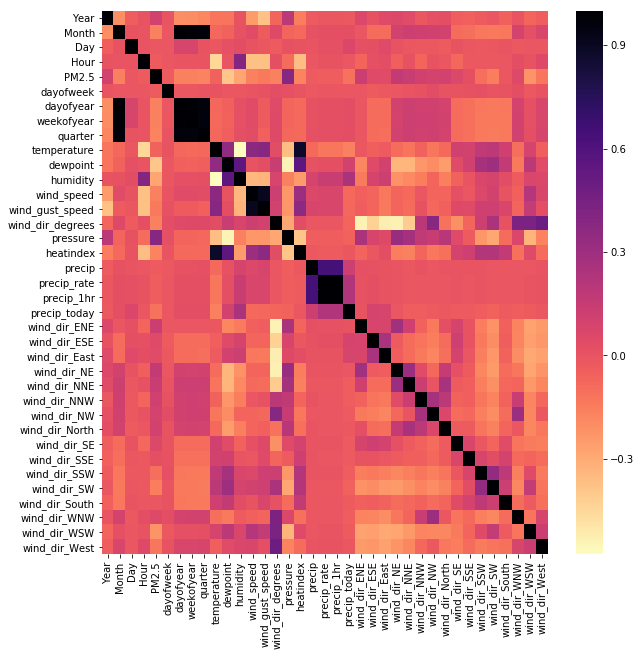

In [12]:
# Linear correlation
df_test = df_merged.drop(df.filter(regex='lag').columns, axis=1)

# calculate the correlation matrix
corr = df_test.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap='magma_r',
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)

print(corr['PM2.5'].sort_values(ascending=False)[:10])
print(corr['PM2.5'].sort_values(ascending=True)[:10])

In [13]:
df_merged.dayofweek = df_merged.dayofweek.apply(str)
df_merged = pd.get_dummies(df_merged, prefix=['dayofweek'])

## Split train/test data

In [14]:
train_percent = 0.7
train = df_merged.iloc[:int(len(df_merged)*train_percent)]
test = df_merged.iloc[int(len(df_merged)*train_percent):]
X_train = train.drop(columns=['PM2.5'])
X_test = test.drop(columns=['PM2.5'])
y_train = train['PM2.5']
y_test = test['PM2.5']

In [15]:
### try y -> y_diff
# y_train = y_train - y_train.shift(1)
# y_test = y_test - y_test.shift(1)

# # cut first nan value of both train/test
# y_train = y_train[1:]
# X_train = X_train[1:]
# y_test = y_test[1:]
# X_test = X_test[1:]

In [16]:
y_test[y_test.isnull()]

Series([], Name: PM2.5, dtype: float64)

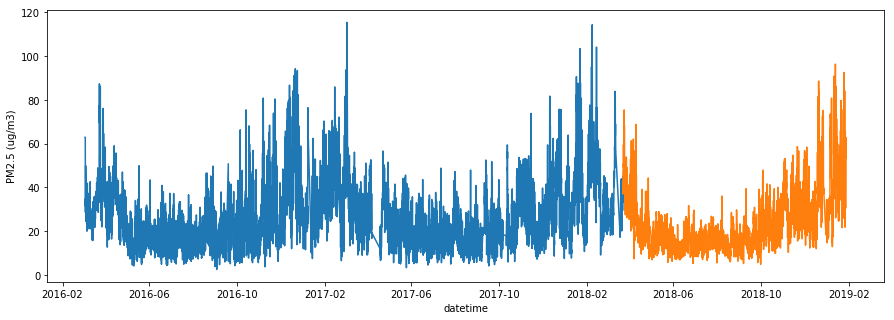

In [17]:
plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
plt.plot(y_train.index, y_train)
plt.plot(y_test.index, y_test)
plt.show()

## Train model

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb.plot_importance(reg, height=0.7, max_num_features=20)

In [ ]:
X_test_pred = reg.predict(X_test)

# Plot test data vs. prediction data
plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
selectdate = 269*24
plt.plot(y_test.index[selectdate:], X_test_pred[selectdate:], label='Predict')
plt.plot(y_test.index[selectdate:], y_test[selectdate:], alpha=0.6, label='Observe')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
plt.plot(y_test.index, X_test_pred, label='Predict')
plt.plot(y_test.index, y_test, alpha=0.6, label='Observe')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Check accuracy
from sklearn.metrics import r2_score
print("Model accuracy: MSE/R-square:")
print(mean_squared_error(y_test, X_test_pred), r2_score(y_test, X_test_pred))
print()

## Use mean-value to predict
print("Mean-value model accuracy: MSE/R-square:")
mean_value = np.mean(y_test)
print(mean_squared_error(y_test, np.ones(len(y_test))*mean_value), r2_score(y_test, np.ones(len(y_test))))

# print()
# ## Use lag-1 predict
# print("Lag-1 model accuracy: MSE/R-square:")
# mean_squared_error(y_test, X_test['lag_1'].values), r2_score(y_test, X_test['lag_1'].values)
## Lag-1 model accuracy: MSE/R-square:
## (10.082567586694974, 0.9482315368050865)


## Model explanation - Dependence plot

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(reg)
X = df_merged.drop(columns=['PM2.5'])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap.dependence_plot("dayofyear", shap_values, X)
shap.dependence_plot("Hour", shap_values, X)
shap.dependence_plot("Day", shap_values, X)
shap.dependence_plot("dewpoint", shap_values, X)
shap.dependence_plot("wind_gust_speed", shap_values, X)
shap.dependence_plot("pressure", shap_values, X)
shap.dependence_plot("humidity", shap_values, X)
shap.dependence_plot("heatindex", shap_values, X)
shap.dependence_plot("temperature", shap_values, X)
shap.dependence_plot("wind_dir_degrees", shap_values, X)
shap.dependence_plot("precip_today", shap_values, X)

In [ ]:
shap_interaction_values = shap.TreeExplainer(reg).shap_interaction_values(X.iloc[-639:,:])
shap.summary_plot(shap_interaction_values, X.iloc[-639:,:])

In [ ]:
# visualize n day prediction explanation
selectdate = '2017-03-03 09:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [ ]:
selectdate = '2018-02-08 10:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [ ]:
df.nsmallest(5, 'PM2.5')
selectdate = '2016-09-02 22:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

In [19]:
selectdate = '2017-05-25 08:00:00'
row = X.index.get_loc(selectdate)
print("Prediction on ",selectdate,", Real value:",df_merged[row:row+1]['PM2.5'].values)
shap.force_plot(explainer.expected_value, shap_values[row,:], X.iloc[row,:])

NameError: name 'X' is not defined